### Imports & Logging Setup

In [95]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


### Load Data & Select Features

In [96]:
import pandas as pd
import os
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load features safely
def load_all_features(file_paths, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue  # Skip processed data file

        if os.path.exists(path):
            df = pd.read_csv(path)
            if key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    # Merge selected features (remove duplicates)
    combined_features = set().union(*feature_sets.values())
    logging.info(f"Total unique features selected: {len(combined_features)}")

    return list(combined_features)

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Create a binary diagnosis column
processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Select top features
num_features_to_select = 10
top_features = load_all_features(file_paths, num_features=num_features_to_select)

# Define target columns
target_column_diagnosis = "diagnosis"
target_column_stage = "stage"
target_column_subtype = "subtype"

2025-02-08 22:48:40,720 - INFO - Total unique features selected: 38


### Process Features & Labels for Multi-Output Classification

In [97]:
def process_features_and_labels(processed_data, selected_features):
    """
    Filters processed data for selected features and extracts multi-output target labels.
    
    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.

    Returns:
        tuple: Processed feature dataframe (X) and label dataframe (y).
    """
    # Check for missing features
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing: {missing_features}")

    # Stop if more than 50% of features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    # Keep only available features
    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Extract features and ensure numeric values
    X = processed_data[selected_features].apply(pd.to_numeric, errors='coerce')

    # Extract labels
    y = processed_data[["diagnosis", "stage", "subtype"]]

    # Check for missing values
    if X.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")

        # Print summary of missing values
        print("\n Missing values per feature (Top 5):")
        missing_counts = X.isnull().sum()
        print(missing_counts[missing_counts > 0].head())

        print("\n Missing values in labels:")
        print(y.isnull().sum())

        # Drop rows with missing values
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize feature values
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    logging.info("Features have been standardized.")

    # Train-Test Split (No SMOTE, just stratified sampling)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y["diagnosis"])

    # Log dataset details
    logging.info(f"Training Set Shape: {X_train.shape}")
    logging.info(f"Test Set Shape: {X_test.shape}")
    logging.info(f"Class distribution in training set:\n{y_train['diagnosis'].value_counts(normalize=True)}")

    return X_train, X_test, y_train, y_test

# Process features and labels
X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features)

# Debugging: Check the prepared data
print("\nExpression values sample:")
print(X_train.head())

print("\nFeature statistics:")
print(X_train.describe())

print("\nClass proportions in train set:")
print(y_train["diagnosis"].value_counts(normalize=True))

2025-02-08 22:48:46,125 - INFO - Features have been standardized.
2025-02-08 22:48:46,129 - INFO - Training Set Shape: (872, 38)
2025-02-08 22:48:46,130 - INFO - Test Set Shape: (219, 38)
2025-02-08 22:48:46,131 - INFO - Class distribution in training set:
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64



Expression values sample:
     hsa-mir-523  hsa-mir-451b  hsa-mir-4300   subtype  hsa-mir-8082  \
459    -0.055121      -0.04749     -0.042693 -0.893706     -0.030289   
765    -0.055121      -0.04749     -0.042693  1.014383     -0.030289   
749    -0.055121      -0.04749     -0.042693  1.014383     -0.030289   
990    -0.055121      -0.04749     -0.042693  1.014383     -0.030289   
270    -0.055121      -0.04749     -0.042693 -0.893706     -0.030289   

     hsa-mir-4637  hsa-mir-3973  hsa-mir-185  hsa-mir-518f     stage  ...  \
459     -0.158588     -0.030289    -1.140265     -0.045815 -0.794040  ...   
765     -0.158588     -0.030289    -0.064177     -0.049625 -0.794040  ...   
749     -0.158588     -0.030289     3.249506     -0.049625  0.376632  ...   
990     -0.158588     -0.030289    -0.413189     -0.049625 -0.794040  ...   
270     -0.158588     -0.030289    -0.099586     -0.048826  1.547305  ...   

     hsa-mir-1181  hsa-mir-6766  hsa-mir-509-1  hsa-mir-4257  hsa-mir-519d  \

### Train-Test Split & Feature Scaling

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Ensure y is a DataFrame
if isinstance(y, pd.Series):
    y = y.to_frame()

# Debugging: Print Columns to Verify
print("Columns in filtered_data:", filtered_data.columns)
print("Columns in y:", y.columns)

# Use filtered_data since we know it contains "diagnosis"
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data.loc[cancer_only, ["stage", "subtype"]]

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\n⚠️ Some classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log Split Information
print("\nTrain-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())

Columns in filtered_data: Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98',
       'hsa-mir-99a', 'hsa-mir-99b', 'stage', 'subtype', 'diagnosis'],
      dtype='object', length=1884)
Columns in y: Index(['diagnosis'], dtype='object')

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Train-Test Split Information:
Diagnosis Model - Training set: (866, 36), Testing set: (217, 36)
Stage & Subtype Model - Training set: (857, 36), Testing set: (215, 36)

Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Training set class distribution (S

### Remove Rare Cases & Finalize Train-Test Split

In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again
expression_values = filtered_data[top_features]

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\n⚠️ Some classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())


Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 38), Testing set: (217, 38)
Stage & Subtype Model - Training set: (857, 38), Testing set: (215, 38)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Updated Testing set class distribution (Stage & Subtype):
stage  subtype
1      1          62
       

### Train Multi-Output SVM Model

In [108]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train Diagnosis SVM (Binary Classification)**
print("\nTraining Diagnosis SVM...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train_diagnosis, y_train_diagnosis)

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test_diagnosis)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test_diagnosis, y_pred_diagnosis))

# Train Stage SVM (Multiclass Classification)**
print("\nTraining Stage SVM...")
svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_cancer["stage"])

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_cancer["stage"], y_pred_stage))

# Train Subtype SVM (Multiclass Classification)**
print("\nTraining Subtype SVM...")
svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_cancer["subtype"])

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_cancer["subtype"], y_pred_subtype))


Training Diagnosis SVM...

Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.92      0.99      0.95       113
           2       1.00      0.94      0.97        62
           3       0.94      0.89      0.91        35
           4       1.00      0.40      0.57         5

    accuracy                           0.94       215
   macro avg       0.96      0.80      0.85       215
weig

### Evaluate Multi-Output Model


-------------------- SVM_Diagnosis Results --------------------

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217


Confusion Matrix:
 [[  2   0]
 [  0 215]]

Confusion matrix saved to ../results/svm/svm_diagnosis_confusion_matrix.png


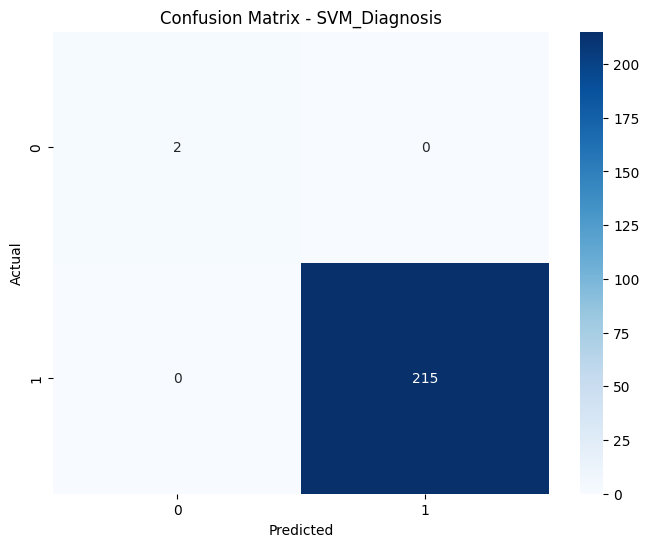

2025-02-08 22:55:51,865 - INFO - 
Model Evaluation Completed for SVM_Diagnosis!
2025-02-08 22:55:51,865 - INFO - Accuracy: 1.0000
2025-02-08 22:55:51,866 - INFO - Confusion Matrix: [[2, 0], [0, 215]]



-------------------- SVM_Stage Results --------------------

Accuracy: 0.9442

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.99      0.95       113
           2       1.00      0.94      0.97        62
           3       0.94      0.89      0.91        35
           4       1.00      0.40      0.57         5

    accuracy                           0.94       215
   macro avg       0.96      0.80      0.85       215
weighted avg       0.95      0.94      0.94       215


Confusion Matrix:
 [[112   0   1   0]
 [  3  58   1   0]
 [  4   0  31   0]
 [  3   0   0   2]]

Confusion matrix saved to ../results/svm/svm_stage_confusion_matrix.png


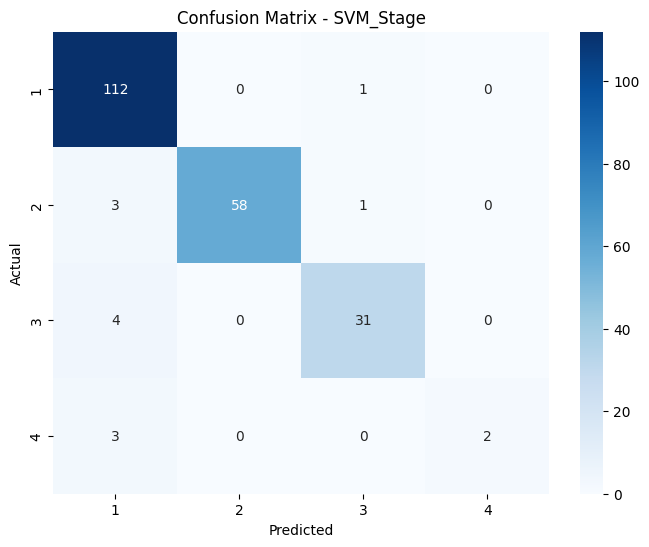

2025-02-08 22:55:52,057 - INFO - 
Model Evaluation Completed for SVM_Stage!
2025-02-08 22:55:52,057 - INFO - Accuracy: 0.9442
2025-02-08 22:55:52,058 - INFO - Confusion Matrix: [[112, 0, 1, 0], [3, 58, 1, 0], [4, 0, 31, 0], [3, 0, 0, 2]]



-------------------- SVM_Subtype Results --------------------

Accuracy: 0.9674

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.95      0.97       112
           2       0.94      0.99      0.97       103

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215


Confusion Matrix:
 [[106   6]
 [  1 102]]

Confusion matrix saved to ../results/svm/svm_subtype_confusion_matrix.png


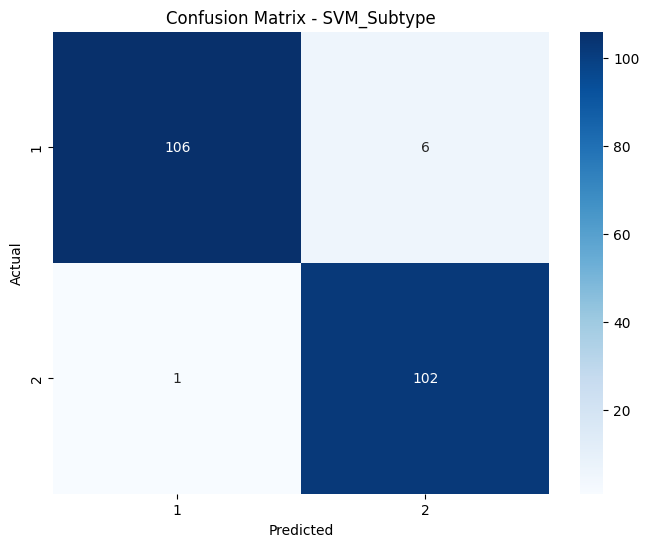

2025-02-08 22:55:52,203 - INFO - 
Model Evaluation Completed for SVM_Subtype!
2025-02-08 22:55:52,204 - INFO - Accuracy: 0.9674
2025-02-08 22:55:52,204 - INFO - Confusion Matrix: [[106, 6], [1, 102]]


In [109]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

def evaluate_model(y_test, y_pred, model_name, save_dir="../results/svm/"):
    """
    Evaluate model performance with accuracy, classification reports, and confusion matrices.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the plot
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")

    plt.show()

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed for {model_name}!")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Confusion Matrix: {cm.tolist()}")

    return {
        "accuracy": accuracy,
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

# Evaluate Diagnosis Model**
metrics_diagnosis = evaluate_model(y_test_diagnosis, y_pred_diagnosis, model_name="SVM_Diagnosis")

# Evaluate Stage Model**
metrics_stage = evaluate_model(y_test_cancer["stage"], y_pred_stage, model_name="SVM_Stage")

# Evaluate Subtype Model**
metrics_subtype = evaluate_model(y_test_cancer["subtype"], y_pred_subtype, model_name="SVM_Subtype")

### Visualize Performance Metrics


Classification Report for Precision, Recall, F1-score - Diagnosis Classification:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217

Metrics comparison saved to ../results/svm/plots/diagnosis_metrics_comparison.png


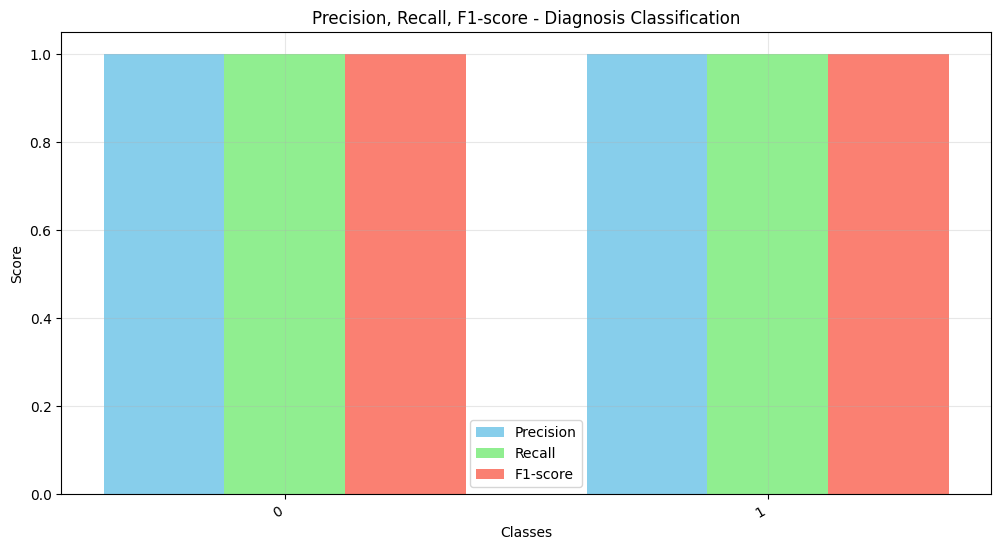


Classification Report for Precision, Recall, F1-score - Stage Classification:

              precision    recall  f1-score   support

           1       0.92      0.99      0.95       113
           2       1.00      0.94      0.97        62
           3       0.94      0.89      0.91        35
           4       1.00      0.40      0.57         5

    accuracy                           0.94       215
   macro avg       0.96      0.80      0.85       215
weighted avg       0.95      0.94      0.94       215

Metrics comparison saved to ../results/svm/plots/stage_metrics_comparison.png


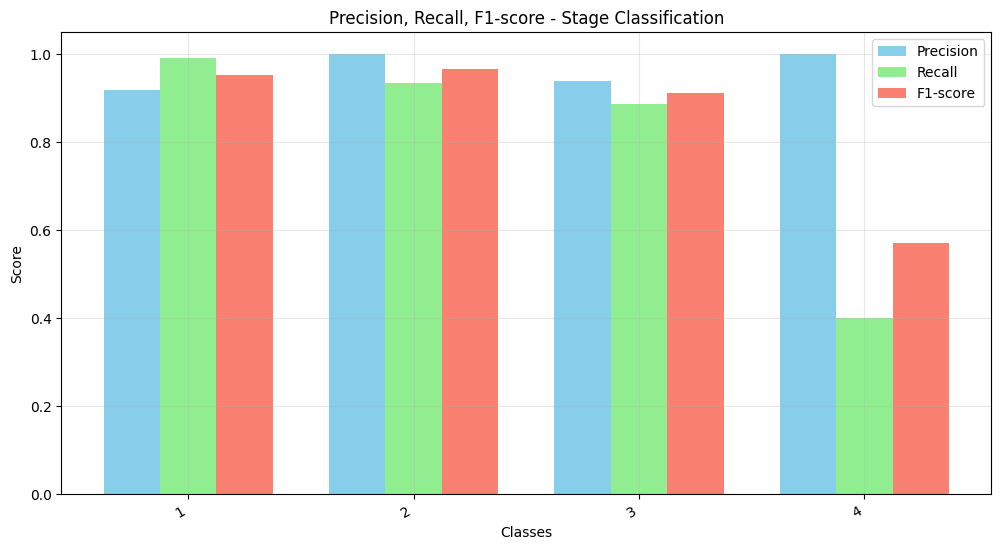


Classification Report for Precision, Recall, F1-score - Subtype Classification:

              precision    recall  f1-score   support

           1       0.99      0.95      0.97       112
           2       0.94      0.99      0.97       103

    accuracy                           0.97       215
   macro avg       0.97      0.97      0.97       215
weighted avg       0.97      0.97      0.97       215

Metrics comparison saved to ../results/svm/plots/subtype_metrics_comparison.png


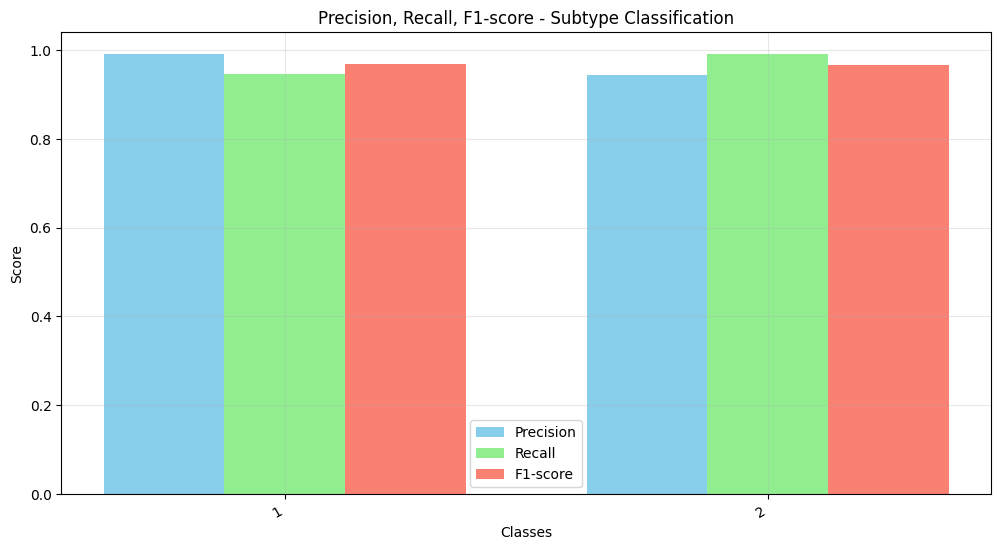

In [110]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define save directory
save_dir = "../results/svm/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_metrics_comparison(y_true, y_pred, labels, title, save_path=None):
    """Plots precision, recall, and F1-score for each class and prints the classification report."""
    report = classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels], output_dict=True)
    
    # Restored Print Output
    print(f"\nClassification Report for {title}:\n")
    print(classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels]))

    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for label in labels:
        label_str = str(label)
        if label_str in report:
            metrics_data['Precision'].append(report[label_str]['precision'])
            metrics_data['Recall'].append(report[label_str]['recall'])
            metrics_data['F1-score'].append(report[label_str]['f1-score'])
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

# Diagnosis Visualization (Now with Print Output)
diagnosis_labels = sorted(y_test_diagnosis.unique())
plot_metrics_comparison(y_test_diagnosis, y_pred_diagnosis, diagnosis_labels, 
                        "Precision, Recall, F1-score - Diagnosis Classification", 
                        save_path=os.path.join(save_dir, "diagnosis_metrics_comparison.png"))

# Stage Visualization (Now with Print Output)
stage_labels = sorted(y_test_cancer["stage"].unique())
plot_metrics_comparison(y_test_cancer["stage"], y_pred_stage, stage_labels, 
                        "Precision, Recall, F1-score - Stage Classification", 
                        save_path=os.path.join(save_dir, "stage_metrics_comparison.png"))

# Subtype Visualization (Now with Print Output)
subtype_labels = sorted(y_test_cancer["subtype"].unique())
plot_metrics_comparison(y_test_cancer["subtype"], y_pred_subtype, subtype_labels, 
                        "Precision, Recall, F1-score - Subtype Classification", 
                        save_path=os.path.join(save_dir, "subtype_metrics_comparison.png"))

### Save Everything & Finalize the Pipeline

In [111]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels for Diagnosis**
predictions_diagnosis_path = os.path.join(output_dir, "svm_predictions_diagnosis.csv")
pd.DataFrame({"actual": y_test_diagnosis, "predicted": y_pred_diagnosis}).to_csv(predictions_diagnosis_path, index=False)
logging.info(f"Diagnosis predictions saved to {predictions_diagnosis_path}")

# Save Predictions & Actual Labels for Stage**
predictions_stage_path = os.path.join(output_dir, "svm_predictions_stage.csv")
pd.DataFrame({"actual": y_test_cancer["stage"], "predicted": y_pred_stage}).to_csv(predictions_stage_path, index=False)
logging.info(f"Stage predictions saved to {predictions_stage_path}")

# Save Predictions & Actual Labels for Subtype**
predictions_subtype_path = os.path.join(output_dir, "svm_predictions_subtype.csv")
pd.DataFrame({"actual": y_test_cancer["subtype"], "predicted": y_pred_subtype}).to_csv(predictions_subtype_path, index=False)
logging.info(f"Subtype predictions saved to {predictions_subtype_path}")

# Save Experiment Metadata**
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_,
    "stage_hyperparameters": grid_stage.best_params_,
    "subtype_hyperparameters": grid_subtype.best_params_,
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "train_set_size_diagnosis": X_train_diagnosis.shape[0],
    "train_set_size_stage": X_train_cancer.shape[0],
    "test_set_size_diagnosis": X_test_diagnosis.shape[0],
    "test_set_size_stage": X_test_cancer.shape[0],
}

metadata_path = os.path.join(output_dir, "svm_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# **5️ Save Trained Models**
model_diagnosis_path = os.path.join(output_dir, "svm_model_diagnosis.pkl")
joblib.dump(best_svm_diagnosis, model_diagnosis_path)
logging.info(f"Diagnosis model saved to {model_diagnosis_path}")

model_stage_path = os.path.join(output_dir, "svm_model_stage.pkl")
joblib.dump(best_svm_stage, model_stage_path)
logging.info(f"Stage model saved to {model_stage_path}")

model_subtype_path = os.path.join(output_dir, "svm_model_subtype.pkl")
joblib.dump(best_svm_subtype, model_subtype_path)
logging.info(f"Subtype model saved to {model_subtype_path}")

print("\n All results successfully saved. The SVM pipeline is complete!")

2025-02-08 22:55:58,076 - INFO - Diagnosis predictions saved to ../results/svm/svm_predictions_diagnosis.csv
2025-02-08 22:55:58,080 - INFO - Stage predictions saved to ../results/svm/svm_predictions_stage.csv
2025-02-08 22:55:58,083 - INFO - Subtype predictions saved to ../results/svm/svm_predictions_subtype.csv
2025-02-08 22:55:58,085 - INFO - Metadata saved to ../results/svm/svm_metadata.json
2025-02-08 22:55:58,088 - INFO - Diagnosis model saved to ../results/svm/svm_model_diagnosis.pkl
2025-02-08 22:55:58,090 - INFO - Stage model saved to ../results/svm/svm_model_stage.pkl
2025-02-08 22:55:58,093 - INFO - Subtype model saved to ../results/svm/svm_model_subtype.pkl



 All results successfully saved. The SVM pipeline is complete!
